# Inspection of DC2 Run 2.2i DR6 Object Table with Dask
### Michael Wood-Vasey (@wmwv)
### Last Verified to Run: 2020-07-08 by MWV

Inspect the Run 2.2i DR6 Object Table
Using a Dask Cluster on one NERSC node as the backend.

#### Run 2.2i DR6a as of 2020-06-04 includes  
  * 78 tracts
  * 52 million objects  
  * 34 million objects with i-band SNR > 5

2. Requires:
```
dask
dask.distributed
holoviews
datashader
bokeh
pyarrow >= 0.13.1
```

These were used with `desc-python-bleed` kernel

3. This was run using the `desc-python-bleed` kernel

We directly use the DPDD Parquet files.

## Import Needed Modules

In [1]:
import math
import os

import numpy as np
from numpy.lib import scimath as SM

import astropy.units as u
import pandas as pd

In [2]:
import dask
from dask.distributed import Client

import dask.dataframe as dd
import datashader as ds
import holoviews as hv
from holoviews.operation.datashader import datashade, shade, dynspread, rasterize

In [3]:
import GCRCatalogs
from GCR import GCRQuery

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

import seaborn as sns

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
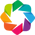

In [5]:
hv.extension('bokeh')

In [6]:
cmap = 'viridis'

## Start our Dask Cluster


For simple testing and illustration of how to use dask, holoview, and datashader here you can run locally on just one tract.
To run on the full set of DR6, you'll need to set up a node to support Dask distributed.  Basically you just need a machine that can hold the data in memory.

### Start a Dask Cluster on an Interactive Nodes

So instead, in a separate Terminal on Cori, ask for a pair of Node from the `interactive` queue.  This generally completes in seconds.  We ask for 2 Nodes because we'd like the full ~256 GB of availablel memory to store the data and the intermediate copies that often get made in some of the plots below:

Move to somewhere SCRATCH directory to simplify file locking
```
cd $SCRATCH/
```

```
salloc -N 2 -C haswell --qos=interactive -t 04:00:00
```

And then once on the first Node, where you'll get put after the `salloc` complets, load the right Python environment:
```
python /global/common/software/lsst/common/miniconda/start-kernel-cli.py desc-python-bleed
```

And then start up the Dask Cluster
```
NUM_WORKERS=16
SCHEDULER_FILE=${SCRATCH}/scheduler.json
dask-scheduler --scheduler-file ${SCHEDULER_FILE} &
dask-worker --nprocs ${NUM_WORKERS} --scheduler-file ${SCHEDULER_FILE} &
```

Then exit the environment and go to the second Node.

```
NUM_WORKERS=16
SCHEDULER_FILE=${SCRATCH}/scheduler.json
dask-worker --nprocs ${NUM_WORKERS} --scheduler-file ${SCHEDULER_FILE} &
```

The nodes will be printed out when the `salloc` launches.  And if you forget, you can look them up under the `SLURM_NODELIST` environment variable.

We connect to this Dask cluster through a shared agreement on where the `SCHEDULER_FILE` is.

In [7]:
scheduler_file = os.path.join(os.environ["SCRATCH"], "scheduler.json")

We then configure the dashboard URL to use the JupyterHub proxy service.
We here set the formatting string template to the correct value.
Once we actually connect the client, then client can then tell us the full link.

In [8]:
dask.config.config["distributed"]["dashboard"]["link"] = "{JUPYTERHUB_SERVICE_PREFIX}proxy/{host}:{port}/status"

In [9]:
client = Client(scheduler_file=scheduler_file)

In [10]:
client

<Client: 'tcp://10.128.0.237:8786' processes=32 threads=128, memory=261.76 GB>

## Define Catalog and Subsampling

In [11]:
data_release = "dr6a"
datafile = f"/global/cfs/cdirs/lsst/shared/DC2-prod/Run2.2i/dpdd/Run2.2i-{data_release}/dc2_object_run2.2i_{data_release}"

In [12]:
restrict_to_tracts = None
# restrict_to_tracts = [3640]

## Load Data

In [13]:
filters = ('u', 'g', 'r', 'i', 'z', 'y')

In [14]:
columns = ['ra', 'dec']
columns += [f'mag_{f}' for f in filters]
columns += [f'magerr_{f}' for f in filters]
columns += [f'mag_{f}_cModel' for f in filters]
columns += [f'magerr_{f}_cModel' for f in filters]
columns += [f'I_flag']
columns += [f'I_flag_{f}' for f in filters]
columns += [f'Ixx_{f}' for f in filters]
columns += [f'Ixy_{f}' for f in filters]
columns += [f'Iyy_{f}' for f in filters]
columns += [f'psf_fwhm_{f}' for f in filters]
columns += ['good', 'extendedness', 'blendedness']

In [15]:
# Select good detections:
#  1. Marked as 'good' in catalog flags.
#  2. SNR in given band > threshold
#  3. In defined simulation range
snr_threshold = 5
snr_filter = 'i'

# We want to do a SNR cut, but magerr is the thing already calculated
# So we'll redefine our SNR in terms of magerr
magerr_cut = (2.5 / np.log(10)) / snr_threshold
snr_cut = f'magerr_{snr_filter} < {magerr_cut}'

In [16]:
# Directly read Parquet file:
# You can define filters for the pyarrow.parquet backend.  See:
# https://arrow.apache.org/docs/python/generated/pyarrow.parquet.ParquetDataset.html
parquet_filters = []
parquet_filters.append((f'magerr_{snr_filter}', '<', magerr_cut))
parquet_filters.append(('good', '==', True))
if restrict_to_tracts is not None:
    parquet_filters.append(('tract', 'in', restrict_to_tracts))

# But the allowed operator list is restricted to: =, ==, !=, <, >, <=, >=, in, not in
# https://arrow.apache.org/docs/_modules/pyarrow/parquet.html#ParquetDataset

# So we can't map the subsampling based on last digit of ObjectId like we do for GCR
# We need to pass use_legacy_data=False to allow for filtering on any columns rather than columsn that are also partition keys.

In [17]:
df = dd.read_parquet(datafile, columns=columns, engine='pyarrow')

In [18]:
# Define color columns
df['u-g'] = df['mag_u'] - df['mag_g']
df['g-r'] = df['mag_g'] - df['mag_r']
df['r-i'] = df['mag_r'] - df['mag_i']
df['i-z'] = df['mag_i'] - df['mag_z']
df['z-y'] = df['mag_z'] - df['mag_y']

In [19]:
good = df[df["good"] & (df[f"magerr_{snr_filter}"] < magerr_cut)]

In [20]:
star = good[good['extendedness'] == 0]
galaxy = good[good['extendedness'] > 0]

In [21]:
print(f'Total: {len(df)}, Good: {len(good)}, Stars: {len(star)}, Galaxies: {len(galaxy)}')

Total: 51802478, Good: 34477764, Stars: 6394878, Galaxies: 28000447


## Persist the data in Dask Cluster Worker memory

Dask actively purges data from memory when its no longer needed by the Dask Task Graph currently doing the computation.

That's not what we want here where we want to plot several quantities repeatedly.  So we explicitly tell Dask to persist this data frame.

In [22]:
good = good.persist()

## Object Density in RA, Dec

DC2 Run 2.x WFD and DDF regions
https://docs.google.com/document/d/18nNVImxGioQ3tcLFMRr67G_jpOzCIOdar9bjqChueQg/view
https://github.com/LSSTDESC/DC2_visitList/blob/master/DC2visitGen/notebooks/DC2_Run2_regionCoords_WFD.ipynb

| Location          | RA (degrees) | Dec (degrees) | RA (degrees) | Dec (degrees) |
|:----------------- |:------------ |:------------- |:------------ |:------------- |
| Region            | WFD          | WFD           | DDF          | DDF           |
| Center            | 61.856114    | -35.79        | 53.125       | -28.100       |
| North-East Corner | 71.462228    | -27.25        | 53.764       | -27.533       |
| North-West Corner | 52.250000    | -27.25        | 52.486       | -27.533       |
| South-West Corner | 49.917517    | -44.33        | 52.479       | -28.667       |
| South-East Corner | 73.794710    | -44.33        | 53.771       | -28.667       |

(Note that the order of the rows above is different than in the DC2 papers.  The order of the rows above goes around the perimeter in order.)

In [23]:
dc2_run2x_wfd = [[71.462228, -27.25], [52.250000, -27.25], [49.917517, -44.33], [73.794710, -44.33]]
dc2_run2x_ddf = [[53.764, -27.533], [52.486, -27.533], [52.479, -28.667], [53.771, -28.667]]

In [24]:
def plot_ra_dec(ra, dec, show_dc2_region=True, bins=100, cmin=10):
    """We're just doing this on a rectilinear grid.
    We should do a projection, of course, but that distortion is tolerable in this space."""
    fig = plt.figure(figsize=(8, 8))
    ax = plt.gca()
    ax.set_aspect(1)

    plt.hist2d(ra, dec, bins=bins, cmin=cmin)
    ax.invert_xaxis()  # Flip to East left
    plt.xlabel('RA [deg]')
    plt.ylabel('Dec [deg]')
    plt.colorbar(shrink=0.5, label='objects / bin')

    if show_dc2_region:
        # This region isn't quite a polygon.  The sides should be curved.
        wfd_region = Polygon(dc2_run2x_wfd, color='red', fill=False)
        ddf_region = Polygon(dc2_run2x_ddf, color='orange', fill=False)
        ax.add_patch(wfd_region)
        ax.add_patch(ddf_region)

        max_delta_ra = dc2_run2x_wfd[3][0] - dc2_run2x_wfd[2][0]
        delta_dec = dc2_run2x_wfd[1][1] - dc2_run2x_wfd[3][1]
        grow_buffer = 0.05
        ax.set_xlim(dc2_run2x_wfd[3][0] + max_delta_ra * grow_buffer,
                    dc2_run2x_wfd[2][0] - max_delta_ra * grow_buffer)
        ax.set_ylim(dc2_run2x_wfd[3][1] - delta_dec * grow_buffer,
                    dc2_run2x_wfd[1][1] + delta_dec * grow_buffer)

In [25]:
# plot_ra_dec(good['ra'], good['dec'])

In [26]:
points_ra_dec = hv.Points(good, kdims=[hv.Dimension('ra', soft_range=(dc2_run2x_wfd[2][0], dc2_run2x_wfd[3][0])),
                                       hv.Dimension('dec', soft_range=(dc2_run2x_wfd[3][1], dc2_run2x_wfd[1][1]))])
ra_dec = datashade(points_ra_dec)

In [27]:
ra_dec

:DynamicMap   []
   :RGB   [ra,dec]   (R,G,B,A)

I don't know how to flip x axis.

The overall object density distribution looks good.  The purple edges are regions where the histgoram bin partially overlaps a tract edge.  Without perfect alignment, one should always expect some partial overlap, but that overlap amount will change.  So the overlap at the top of a row of tracts remains constant, but the edge overlap between the RA bounds of each tract will be different, so some are purple, some are blue, and some are green above.

Notes:
* We're missing the DDF region, which was specifically not included in this processing
* There are also a few patches that failed within the main region.
* There is an overall gradient N/S in object density, because we're plotting in rectilinear RA, Dec bins, which means that bins at the bottom in RA cover less area than those at the top.

See the input visit coverage map here:
https://github.com/LSSTDESC/ImageProcessingPipelines/issues/97#issuecomment-498303504


## Color-Color Diagrams and the Stellar Locus

In [28]:
# We refer to a file over in `tutorials/assets' for the stellar locus
datafile_davenport = '../tutorials/assets/Davenport_2014_MNRAS_440_3430_table1.txt'

def get_stellar_locus_davenport(color1='gmr', color2='rmi',
                                datafile=datafile_davenport):
    color1 = color1.replace('-', 'm')
    color2 = color2.replace('-', 'm')

    data = pd.read_table(datafile, sep='\s+', header=1)
    return data[color1], data[color2]

    
def plot_stellar_locus(color1='gmr', color2='rmi',
                       color='blue', linestyle='--', linewidth=2.5,
                       ax=None):

    model_gmr, model_rmi = get_stellar_locus_davenport(color1, color2)
    plot_kwargs = {'linestyle': linestyle, 'linewidth': linewidth, 'color': color,
                   'scalex': False, 'scaley': False}
    if not ax:
        ax = fig.gca()

    ax.plot(model_gmr, model_rmi, **plot_kwargs)

In [29]:
import colorcet

In [30]:
def plot_color_color_hv(df, color1, color2, 
                     range1=(-1, +2), range2=(-1, +2),
                     cmin=10, cmap='gist_heat_r',
                     vmin=None, vmax=None):
    """Plot a color-color diagram.  Overlay stellar locus"""
    band1, band2 = color1[0], color1[-1]
    band3, band4 = color2[0], color2[-1]

    clean = df[np.isfinite(df[color1]) & np.isfinite(df[color2])]
    points_color1_color2 = hv.Points(
        clean,
        kdims=[
            hv.Dimension(color1, range=range1),
            hv.Dimension(color2, range=range2)]
    )

    color1_color2 = datashade(points_color1_color2, cmap=colorcet.blues)

    try:
        color1_m = color1.replace('-', 'm')
        color2_m = color2.replace('-', 'm')

        model_color1, model_color2 = get_stellar_locus_davenport(color1_m, color2_m)
        model_df = pd.DataFrame({color1: model_color1, color2: model_color2})
        stellar_locus = hv.Path(model_df).opts(color='red', line_width=4)
        color1_color2 = color1_color2 * stellar_locus
    except KeyError as e:
        print(f"Couldn't plot Stellar Locus model for {color1}, {color2}")
        
    return color1_color2

In [31]:
def plot_four_color_color(cat, vmin=0, vmax=50000):
    fig, axes = plt.subplots(2, 2, figsize=(8, 6))

    colors = ['umg', 'rmi', 'imz', 'zmy']
    ref_color = 'gmr'
    for ax, color in zip(axes.flat, colors):
        try:
            im = plot_color_color(cat, ref_color, color, ax=ax,
                                 vmin=vmin, vmax=vmax)
            ax.set_ylim(-1, +2)
        except KeyError:
            continue
            
    fig.colorbar(im)
    plt.tight_layout()



In [32]:
mag_columns = [f"mag_{filt}" for filt in filters]

In [33]:
layout = hv.Layout(
    plot_color_color_hv(good, 'g-r', 'u-g') + \
    plot_color_color_hv(good, 'g-r', 'r-i') + \
    plot_color_color_hv(good, 'g-r', 'i-z') + \
    plot_color_color_hv(good, 'g-r', 'z-y'))
layout = layout.cols(2)

Couldn't plot Stellar Locus model for g-r, z-y


:Layout
   .DynamicMap.I   :DynamicMap   []
      :Overlay
         .RGB.I  :RGB   [g-r,u-g]   (R,G,B,A)
         .Path.I :Path   [g-r,u-g]
   .DynamicMap.II  :DynamicMap   []
      :Overlay
         .RGB.I  :RGB   [g-r,r-i]   (R,G,B,A)
         .Path.I :Path   [g-r,r-i]
   .DynamicMap.III :DynamicMap   []
      :Overlay
         .RGB.I  :RGB   [g-r,i-z]   (R,G,B,A)
         .Path.I :Path   [g-r,i-z]
   .DynamicMap.IV  :DynamicMap   []
      :RGB   [g-r,z-y]   (R,G,B,A)

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError


Note that the above panels will zoom in g-r together because Holovies knows that they share this data column.  There is no brushing (selection) and linking.

Couldn't plot Stellar Locus model for gmr, zmy


Text(0.5, 1.0, 'Good objects')

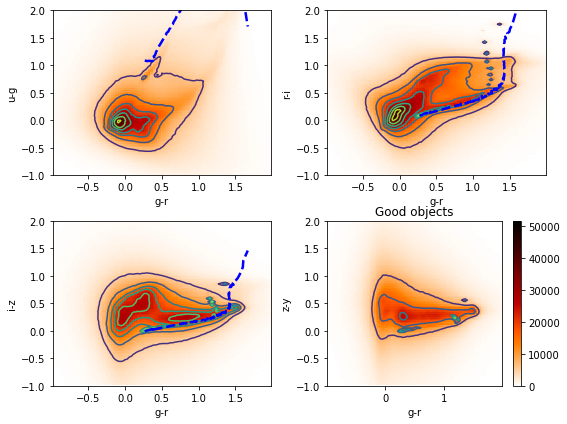

In [32]:
plot_four_color_color(good[mag_columns], vmax=len(good)/1e3)
plt.title("Good objects")

KeyboardInterrupt: 

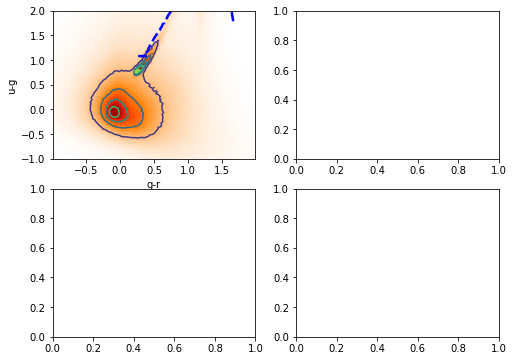

In [33]:
plot_four_color_color(star[mag_columns], vmax=len(star)/1e3)
plt.title("Stars")

The discrete islands in the data for stellar color-color plot -- most visible in `r-i` vs. `g-r` at g-r ~= 1.2 mag -- are due to the finite set of stellar models used for simulating M dwarfs.

------
Let's plot the galaxies on the same color-color plots

Clearly one doesn't expect the galaxies to follow the stellar locus.  But including the stellar locus lines makes it easy to guide the eye between the stars-only and the galaxies-only plots.  

In [ ]:
plot_four_color_color(df.loc[galaxy_idx, mag_columns], vmax=len(galaxy_idx)/1e3)
plt.title("Galaxies")

Questions for further study:
   1. Is there a better comparison sample for the stellar locus than the Davenport reference?
   2. Why is the stellar locus in the Davenport 0.1--0.2 mag redder for the reddest stars than the observed data.  Are there different extinction assumptions (this should be a low-extinction region).  Are there different bandpasses used?

## 1D Density Plots

In [ ]:
def plot_mag(df, filt, good_idx, star_idx, galaxy_idx, log=True, range=(16, 28), ax=None, ):
    if ax is None:
        ax = fig.gca()
    mag = f'mag_{filt}'
    ax.hist([df.loc[good_idx, mag], df.loc[star_idx, mag], df.loc[galaxy_idx, mag]],
            label=['good', 'star', 'galaxy'],
            log=log,
            range=range,
            bins=np.linspace(*range, 100),
            histtype='step')
    ax.set_xlabel(filt)
    ax.set_ylabel('objects / bin')
    ax.set_xlim(range)
    ax.set_ylim(bottom=10)
    ax.legend(loc='upper left')

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
for ax, filt in zip(axes.flat, filters):
    plot_mag(df, filt, good_idx, star_idx, galaxy_idx, ax=ax, range=(16, 32))
    
plt.tight_layout()

The sharp cut in i-band is because that was the reference band for most detections.  The distributions in the other bands extend to 28th mag because many of the forced-photometry measurements are consistent with 0.

To compare number densities, we have to calculate the area covered by each catalog.
We'll use Healpix through HealPy to pixelate the region and then count of the number of pixels with significant numbers of objects.

In [ ]:
def calculate_area(cat, threshold=0.25, nside=1024, verbose=False):
    """Calculate the area covered by a catalog with 'ra', 'dec'
    
    Parameters:
    --
    cat: DataFrame, dict-like with 'ra', 'dec', keys
    threshold:  float
        Fraction of median value required to count a pixel.
    nside:  int
        Healpix NSIDE.  NSIDE=1024 is ~12 sq arcmin/pixel, NSIDE=4096 is 0.74 sq. arcmin/pixel
        Increasing nside will decrease calculated area as holes become better resolved 
        and relative Poisson fluctuations in number counts become more significant.
    verbose:  bool
        Print details on nside, number of significant pixels, and area/pixel.
        
    Returns:
    --
    area:  Astropy Quantity.
    """
    import healpy as hp

    indices = hp.ang2pix(nside, cat['ra'], cat['dec'], lonlat=True)
    idx, counts = np.unique(indices, return_counts=True)
    
    # Take the 25% of the median value of the non-zero counts/pixel
    threshold_counts = threshold * np.median(counts)

    if verbose:
        print(f'Median {np.median(counts)} objects/pixel')
        print(f'Only count pixels with more than {threshold_counts} objects')

    significant_pixels, = np.where(counts > threshold_counts)
    area_pixel = hp.nside2pixarea(nside, degrees=True) * u.deg**2

    if verbose:
        print(f'Pixel size ~ {hp.nside2resol(nside, arcmin=True) * u.arcmin:0.2g}')
        print(f'nside: {nside}, area/pixel: {area_pixel:0.4g}, num significant pixels: {len(significant_pixels)}')

    area = len(significant_pixels) * area_pixel

    if verbose:
        print(f'Total area: {area:0.7g}')
    
    return area

In [ ]:
area_dc2 = calculate_area(df.loc[galaxy_idx, ['ra', 'dec']])
print(f'DC2 Run 2.2i area: {area_dc2:0.2f}')

In [ ]:
num_den_dc2 = sampling_factor * len(galaxy_idx) / area_dc2

# Change default expression to 1/arcmin**2
num_den_dc2 = num_den_dc2.to(1/u.arcmin**2)

In [ ]:
# Now we plot the *normalized* i-band magnitude distributions in Run 2.2i and HSC.
# They are normalized so we can focus on the shape of the distribution.
# However, the legend indicates the total number density of galaxies selected with our magnitude cut,
# which lets us find issues with the overall number density matching (or not).

max_mag_i = 27
plt.figure(figsize=(8, 8))
nbins = 50
mag_range = [20, max_mag_i]
data_to_plot = df.loc[galaxy_idx, 'mag_i']
labels_to_plot = [
    f'Run 2.2i object catalog: {num_den_dc2.value:.1f} {num_den_dc2.unit:fits}',
]
plt.hist(data_to_plot, nbins, range=mag_range, histtype='step',
         label=labels_to_plot, linewidth=2.0, density=True)
    
plt.legend(loc='upper left')
plt.xlabel('i-band magnitude')
plt.ylabel('normalized distribution')
plt.yscale('log')
plt.savefig('dc2_object_run2.2i_galaxy_counts.pdf')

## Magnitude Error vs. Magnitude

The magnitude uncertainties come directly from the poisson estimates of the flux measurements.  By construction they will follow smooth curves.  We here confirm that they do.

In [ ]:
def plot_mag_magerr(df, band, ax=None, range=(16, 28), magerr_limit=0.25, vmin=100):
    # vmin=100 is reasonable for a ~50 million objects
    # If testing with one tract or a large subsampling factor, choose a smaller vmin.
    # Restrict to reasonable range
    mag_col, magerr_col = f'mag_{band}', f'magerr_{band}'
    good = df[df[magerr_col] < magerr_limit]

    ax.hexbin(good[mag_col], good[magerr_col], vmin=vmin)
    ax.set_xlabel(band)
    ax.set_ylabel(f'{band} err');
    ax.set_ylim(0, magerr_limit)

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
for ax, filt in zip(axes.flat, filters):
    mag_col, magerr_col = f'mag_{filt}', f'magerr_{filt}'
    plot_mag_magerr(df.loc[galaxy_idx, [mag_col, magerr_col]], filt, ax=ax)
plt.tight_layout()

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
for ax, filt in zip(axes.flat, filters):
    mag_col, magerr_col = f'mag_{filt}', f'magerr_{filt}'
    plot_mag_magerr(df.loc[star_idx, [mag_col, magerr_col]], filt, ax=ax)
plt.tight_layout()

## Blendedness

Blendedness is a measure of how much the identified flux from an object is affected by overlapping from other objects.

See Bosch et al., 2018, Section 4.9.11.

In [ ]:
w, = np.where(np.isfinite(df.loc[good_idx, 'blendedness']))

In [ ]:
print(f'{100 * len(w)/len(good_idx):0.1f}% of objects have finite blendedness measurements.')

Question for futher study:  What happened to yield non-finite blendedness measurements?

In [ ]:
good_blendedness = good & np.isfinite(df['blendedness'])
plt.hexbin(df.loc[good_blendedness, 'mag_i'], df.loc[good_blendedness, 'blendedness'],
          bins='log', vmin=10);
plt.xlabel('i')
plt.ylabel('blendedness');
plt.colorbar(label='objects / bin');

### Extendedness
 
Extendedness is essentially star/galaxy separation based purely on morphology in the main detected reference band (which is `i` for most Objects).

Extendedness a binary property in the catalog, so it's either 0 or 1.

In [ ]:
plt.hexbin(df.loc[good_idx, 'mag_i'], df.loc[good_idx, 'extendedness'],
           extent=(14, 26, -0.1, +1.1),
           bins='log', vmin=10);
plt.xlabel('i')
plt.ylabel('extendedness');
plt.ylim(-0.1, 1.1)
plt.text(19, 0.1, "STARS", fontdict={'fontsize': 24}, color='orange')
plt.text(19, 0.8, "GALAXIES", fontdict={'fontsize': 24}, color='orange')
plt.colorbar(label='objects / bin');

While the first plot above made extendedness look like a simple binary property, the truth is more complicated.

As galaxies get smaller in angular size and lower in signal-to-noise ratio, it becomes harder to clearly distinguish stars from galaxies.

Extendedness is based off of the difference between the point-source model and extended model brightness.  Specifically objects with `mag_psf - mag_cmodel > 0.164` mag are labeled with `extendedness=1` (i.e., galaxies).

See Bosch et al. 2018, Section 4.9.10 for details.

In [ ]:
plt.axvline(0.0164, 0.4, 1, color='red', linestyle='--',
           label=r'0.0164 $\Delta$mag cut')  # psf-cModel mag cut from Bosch et al. 2018.

plt.hist([df.loc[good_idx, 'mag_i'] - df.loc[good_idx, 'mag_i_cModel'],
         df.loc[star_idx, 'mag_i'] - df.loc[star_idx, 'mag_i_cModel'],
         df.loc[galaxy_idx, 'mag_i'] - df.loc[galaxy_idx, 'mag_i_cModel']],
         label=['Good', 'Stars', 'Galaxies'],
         bins=np.linspace(-0.1, 0.1, 201),
         histtype='step')

plt.legend()
plt.xlabel('mag_i[_psf] - mag_i_CModel');
plt.ylabel('objects / bin')

plt.text(0.25, 0.04, "STARS", transform=plt.gca().transAxes, fontdict={'fontsize': 24}, color='orange');
plt.text(0.65, 0.04, "GALAXIES", transform=plt.gca().transAxes, fontdict={'fontsize': 24}, color='orange')


In [ ]:
plt.hexbin(df.loc[good_idx, 'mag_i'], df.loc[good_idx, 'mag_i'] - df.loc[good_idx, 'mag_i_cModel'],
           extent=(14, 26, -0.75, +2.5),
           bins='log');
plt.xlabel('i')
plt.ylabel('mag_i[_psf] - mag_i_CModel');
plt.text(14.5, -0.5, "STARS", fontdict={'fontsize': 24}, color='orange')
plt.text(18, 2, "GALAXIES", fontdict={'fontsize': 24}, color='orange')
plt.colorbar(label='objects / bin');

plt.axhline(0.0164, 0.92, 1.0, color='red', linestyle='--')
plt.axhline(0.0164, 0, 0.1, color='red', linestyle='--',
            label=r'0.0164 $\Delta$mag cut');  # psf-cModel mag cut from Bosch et al. 2018.

We can zoom in a little to see how the fixed 0.0164 mag cut works at the low SNR limit.  Specifically at mag 24, we're starting to run out of stars and most things are galaxies.  But that's a population prior, it's not something visible using just morphology information.

You can see the effect of lower SNR measurements as the horizontal line at $\Delta$mag=0 puff up due to increased uncertainties.

In [ ]:
plt.hexbin(df.loc[good_idx, 'mag_i'], df.loc[good_idx, 'mag_i'] - df.loc[good_idx, 'mag_i_cModel'],
           extent=(22, 25.5, -0.1, +0.5),
           bins='log');
plt.xlabel('i')
plt.ylabel('mag_i[_psf] - mag_i_CModel');
plt.colorbar(label='objects / bin');

plt.axhline(0.0164, 0, 1, color='red', linestyle='--',
            label=r'0.0164 $\Delta$mag cut');  # psf-cModel mag cut from Bosch et al. 2018.

If we add in color information, 

In [ ]:
plt.hexbin(df.loc[good_idx, 'mag_g'] - df.loc[good_idx, 'mag_r'], df.loc[good_idx, 'mag_i'] - df.loc[good_idx, 'mag_i_cModel'],
           extent=(-2, +3, -0.5, +5),
           bins='log');
plt.xlabel('g-r')
plt.ylabel('mag_i[_psf] - mag_i_CModel');
# plt.text(14.5, 0.3, "STARS", fontdict={'fontsize': 24}, color='orange')
# plt.text(18, 2, "GALAXIES", fontdict={'fontsize': 24}, color='orange')
plt.colorbar(label='objects / bin');

In [ ]:
plt.hist([df.loc[galaxy_idx, 'mag_g'] - df.loc[galaxy_idx, 'mag_r'], df.loc[star_idx, 'mag_g'] - df.loc[star_idx, 'mag_r']],
        label=['galaxies', 'stars'], histtype='step',
        bins=np.linspace(-5, +5, 501));
plt.xlabel('g-r')
plt.ylabel('objects / bin')

In [ ]:
plt.hexbin(df.loc[star_idx, 'mag_g'] - df.loc[star_idx, 'mag_r'], df.loc[star_idx, 'mag_i'] - df.loc[star_idx, 'mag_i_cModel'],
           extent=(-2, +3, -0.5, +5),
           bins='log');
plt.xlabel('g-r')
plt.ylabel('mag_i[_psf] - mag_i_CModel');
# plt.text(14.5, 0.3, "STARS", fontdict={'fontsize': 24}, color='orange')
# plt.text(18, 2, "GALAXIES", fontdict={'fontsize': 24}, color='orange')
plt.colorbar(label='objects / bin');

## Shape Parameters

Ixx, Iyy, Ixy

In [ ]:
def plot_shape(df, filt, good_idx, star_idx, galaxy_idx, ax=None, legend=True):
    if not ax:
        ax = fig.gca()

    names = ['good', 'star', 'galaxy']
    colors = ['blue', 'orange', 'green']
    hist_kwargs = {'color': colors, 'log': True,
             'bins': np.logspace(-1, 1.5, 100),
             'range': (0, 50),
             'histtype': 'step'}
    for prefix, ls in (('Ixx', '-'), ('Iyy', '--'), ('Ixy', ':')):
        field = f'{prefix}_{filt}'
        labels = [f'{prefix} {name}' for name in names]
        ax.hist([df.loc[good_idx, field], df.loc[star_idx, field], df.loc[galaxy_idx, field]],
                label=labels,
                linestyle=ls,
                **hist_kwargs)

    ax.set_ylim(100, ax.get_ylim()[1])
    
    ax.set_xlabel(f'{filt}-band Moments: Ixx, Iyy, Ixy [pixels^2]')
    ax.set_ylabel('objects / bin')
    if legend:
        ax.legend()

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
legend = True
for ax, filt in zip(axes.flat, filters):
    plot_shape(df, filt, good_idx, star_idx, galaxy_idx, ax=ax, legend=legend)
    legend = False
plt.tight_layout()

The stars (orange) are concentrated at low values of the source moments.

Would be interesting to
1. Look by magnitude or SNR to undersatnd the longer tail.  Are these galaxies mis-classified as stars, or are these noise sources?
2. Distribution of ellipticity (see validate_drp to type this right)

In [ ]:
def ellipticity(I_xx, I_xy, I_yy):
    """Calculate ellipticity from second moments.

    Parameters
    ----------
    I_xx : float or numpy.array
    I_xy : float or numpy.array
    I_yy : float or numpy.array

    Returns
    -------
    e, e1, e2 : (float, float, float) or (numpy.array, numpy.array, numpy.array)
        Complex ellipticity, real component, imaginary component
        
    Copied from https://github.com/lsst/validate_drp/python/lsst/validate/drp/util.py
    """
    e = (I_xx - I_yy + 2j*I_xy) / (I_xx + I_yy + 2*SM.sqrt(I_xx*I_yy - I_xy*2))
    e1 = np.real(e)
    e2 = np.imag(e)
    return e, e1, e2

In [ ]:
def plot_ellipticity(df, filt, good_idx, star_idx, galaxie_idx, ax=None, legend=True):
    if not ax:
        ax = fig.gca()

    names = ['good', 'star', 'galaxy']
    colors = ['blue', 'orange', 'green']
    hist_kwargs = {'color': colors, 'log': True,
             'bins': np.logspace(-1, 1.5, 100),
             'range': (0, 5),
             'histtype': 'step'}
    for prefix, ls in (('e', '-'), ('e1', '--'), ('e2', ':')):
        field = f'{prefix}_{filt}'
        labels = [f'{prefix} {name}' for name in names]
        ax.hist([df.loc[good_idx, field], df.loc[star_idx, field], df.loc[galaxy_idx, field]],
                label=labels,
                linestyle=ls,
                **hist_kwargs)

    ax.set_xlim(0, 20)
    ax.set_ylim(10)
    
    ax.set_xlabel(f'{filt}-band ellipticity')
    ax.set_ylabel('objects / bin')
    if legend:
        ax.legend()

In [ ]:
for filt in filters:
    df[f'e_{filt}'], df[f'e1_{filt}'], df[f'e2_{filt}'] = \
    ellipticity(df[f'Ixx_{filt}'], df[f'Ixy_{filt}'], df[f'Iyy_{filt}'])

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
legend = True
for ax, filt in zip(axes.flat, filters):
    plot_ellipticity(df, filt, good_idx, star_idx, galaxy_idx, ax=ax, legend=legend)
    legend = False
plt.tight_layout()

### FWHM of the PSF
At the location of the catalog objects.

The Object Table stores the shape parameters of the PSF model as evaluated at the location of the object.

This is not the same as, but is certainly related to, the distribution of effective seeing in the individual images that made up the coadd.

In [ ]:
def plot_psf_fwhm(df, filters=filters,
                 colors=('purple', 'blue', 'green', 'orange', 'red', 'brown')):
    for filt, color in zip(filters, colors):
        psf_fwhm = np.array(df.loc[good_idx, f'psf_fwhm_{filt}'])
        w, = np.where(np.isfinite(psf_fwhm) & (psf_fwhm < 3))
        sns.distplot(psf_fwhm[w], label=filt, color=color)
    plt.xlabel('PSF FWHM [arcsec]')
    plt.ylabel('normalized object density')
    plt.legend()

In [ ]:
def plot_psf_fwhm(
    df,
    filters,
    colors=("purple", "blue", "green", "orange", "red", "brown"),
    max_psf_fwhm=1.5,
    plotname=None,
):
    bins = np.linspace(0, max_psf_fwhm, 201)
    for filt, color in zip(filters, colors):
        psf_fwhm = df[f"psf_fwhm_{filt}"].to_numpy()
        (w,) = np.where(np.isfinite(psf_fwhm) & (psf_fwhm < max_psf_fwhm))
        plt.hist(psf_fwhm[w], label=filt, color=color, histtype='step',
                bins=bins)
    plt.xlabel("PSF FWHM [arcsec]")
    plt.ylabel("Objects/bin")
    plt.legend()

    plt.tight_layout()
    if plotname is not None:
        plt.savefig(plotname)

In [ ]:
psf_fwhm_filters = [f"psf_fwhm_{filt}" for filt in filters]
plot_psf_fwhm(df.loc[good_idx, psf_fwhm_filters], filters)

This is the PSF model at the location of the objects on the coadd.